# general process

## 1.proprocess lables


###       single lables  
       

### labels categories

## 2.building and training moldels


### different moldels for different categories

#### 1） weather大类有clear, partly_cloudy, haze, cloudy四种。本代码将训练集中含有这四个标签的图片分类了出来。
fname，fname1，fname2，fname3是最终结果。这四个是数组类型，里面含有clear, partly_cloudy, haze, cloudy对应图像在训练集中的名字

#### 2）到目前为止准确度最高的模型：
    将输入图片reshape成64*64的
    使用4卷积层＋3池化层＋1全链接＋1softmax层
    learning rate e^-4

## 3.test

In [1]:
import sys
import os
import subprocess

from six import string_types

# Make sure you have all of these packages installed, e.g. via pip
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display
import cv2
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras import regularizers
%matplotlib inline

Using TensorFlow backend.


In [2]:
PLANET_KAGGLE_ROOT = os.path.abspath("/Users/sunchenxi/Desktop/lab/kaggle/amazon/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

In [3]:
#读取train set标签
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


### all single lebels

In [4]:
# 创建一个list里面有所有标签
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

## one-hot

In [6]:
#进行one－hot编码 数据预处理
#对每一个图像的标签进行标记，有此标签为1
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
labels_df.head()#显示几个看看

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [7]:
labels_df.values[26758]

array(['train_26758', 'cloudy', 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0], dtype=object)

In [8]:
#统计每一个单标签的图像个数
labels_df_sum=labels_df[label_list].sum().sort_values()
labels_df_sum

blow_down               98
conventional_mine      100
slash_burn             209
blooming               332
artisinal_mine         339
selective_logging      340
bare_ground            862
cloudy                2089
haze                  2697
habitation            3660
cultivation           4477
partly_cloudy         7261
water                 7411
road                  8071
agriculture          12315
clear                28431
primary              37513
dtype: int64

In [9]:
#获取含有tags标签的n张图片
def sample_images(tags, n=None):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, string_types): #tag是否是string类型
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == 1
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]

In [10]:
def load_image(filename):
    '''Look through the directory tree to find the image you specified
    (e.g. train_10.tif vs. train_10.jpg)'''
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, dirname, filename))
        if os.path.exists(path):
            print('Found image {}'.format(path))
            return io.imread(path)
    print('Load failed: could not find image {}'.format(path))
 
 #将图片在数组中的位置变成名称
def sample_to_fname(sample_df, row_idx, suffix='jpg'):
    '''Given a dataframe of sampled images, get the
    corresponding filename.'''
    fname = sample_df.get_value(sample_df.index[row_idx], 'image_name')
    return '{}.{}'.format(fname, suffix)

## clear  images

##### 计算出label＝clear的图像个数

In [11]:
len(labels_df)

40479

In [12]:
n=0
for i in range(len(labels_df)):
    if(labels_df["clear"][i]==1):
        n=n+1

In [13]:
n

28431

#### 获得含有clear的图片的名字

In [14]:
fname=[0]*n
s = sample_images(['clear'], n=n)
for i in range(n):
    fname[i]= sample_to_fname(s, i)#获得了文件名

##### 图片名字是：

In [15]:
fname

['train_6035.jpg',
 'train_23509.jpg',
 'train_40253.jpg',
 'train_8442.jpg',
 'train_1544.jpg',
 'train_595.jpg',
 'train_20739.jpg',
 'train_2347.jpg',
 'train_40273.jpg',
 'train_20238.jpg',
 'train_22603.jpg',
 'train_30995.jpg',
 'train_10033.jpg',
 'train_27585.jpg',
 'train_23988.jpg',
 'train_5164.jpg',
 'train_4547.jpg',
 'train_18348.jpg',
 'train_23378.jpg',
 'train_30152.jpg',
 'train_37145.jpg',
 'train_38292.jpg',
 'train_38143.jpg',
 'train_17242.jpg',
 'train_25584.jpg',
 'train_23855.jpg',
 'train_26360.jpg',
 'train_34705.jpg',
 'train_12757.jpg',
 'train_18713.jpg',
 'train_6029.jpg',
 'train_4402.jpg',
 'train_23037.jpg',
 'train_6206.jpg',
 'train_2064.jpg',
 'train_11881.jpg',
 'train_12823.jpg',
 'train_36005.jpg',
 'train_27498.jpg',
 'train_12279.jpg',
 'train_34851.jpg',
 'train_2592.jpg',
 'train_1511.jpg',
 'train_38251.jpg',
 'train_23595.jpg',
 'train_1925.jpg',
 'train_11800.jpg',
 'train_4160.jpg',
 'train_26872.jpg',
 'train_1353.jpg',
 'train_30046.jpg

## partly_cloudy images

##### 同样的方法获取含有partly_cloudy标签的图片名称

In [16]:
n1=0
for i in range(len(labels_df)):
    if(labels_df["partly_cloudy"][i]==1):
        n1=n1+1

In [17]:
n1

7261

In [18]:
fname1=[0]*n1
s = sample_images(['partly_cloudy'], n=n1)
for i in range(n1):
    fname1[i]= sample_to_fname(s, i)#获得了文件名

In [19]:
fname1

['train_32527.jpg',
 'train_32697.jpg',
 'train_33129.jpg',
 'train_11293.jpg',
 'train_38327.jpg',
 'train_12929.jpg',
 'train_28943.jpg',
 'train_21242.jpg',
 'train_30028.jpg',
 'train_25632.jpg',
 'train_19289.jpg',
 'train_3816.jpg',
 'train_21636.jpg',
 'train_35857.jpg',
 'train_16543.jpg',
 'train_2419.jpg',
 'train_22940.jpg',
 'train_11374.jpg',
 'train_6254.jpg',
 'train_32075.jpg',
 'train_24493.jpg',
 'train_14631.jpg',
 'train_13923.jpg',
 'train_17110.jpg',
 'train_39459.jpg',
 'train_10372.jpg',
 'train_1702.jpg',
 'train_19249.jpg',
 'train_20788.jpg',
 'train_29571.jpg',
 'train_34390.jpg',
 'train_27951.jpg',
 'train_34448.jpg',
 'train_39180.jpg',
 'train_23567.jpg',
 'train_31231.jpg',
 'train_36948.jpg',
 'train_10696.jpg',
 'train_9401.jpg',
 'train_19070.jpg',
 'train_25149.jpg',
 'train_10104.jpg',
 'train_9359.jpg',
 'train_23362.jpg',
 'train_17933.jpg',
 'train_36085.jpg',
 'train_37385.jpg',
 'train_28018.jpg',
 'train_13824.jpg',
 'train_25545.jpg',
 'trai

## haze images

##### 获取含有haze的图片的名称

In [20]:
n2=0
for i in range(len(labels_df)):
    if(labels_df["haze"][i]==1):
        n2=n2+1
fname2=[0]*n1
s = sample_images(['haze'], n=n2)
for i in range(n2):
    fname2[i]= sample_to_fname(s, i)#获得了文件名        

In [21]:
fname

['train_6035.jpg',
 'train_23509.jpg',
 'train_40253.jpg',
 'train_8442.jpg',
 'train_1544.jpg',
 'train_595.jpg',
 'train_20739.jpg',
 'train_2347.jpg',
 'train_40273.jpg',
 'train_20238.jpg',
 'train_22603.jpg',
 'train_30995.jpg',
 'train_10033.jpg',
 'train_27585.jpg',
 'train_23988.jpg',
 'train_5164.jpg',
 'train_4547.jpg',
 'train_18348.jpg',
 'train_23378.jpg',
 'train_30152.jpg',
 'train_37145.jpg',
 'train_38292.jpg',
 'train_38143.jpg',
 'train_17242.jpg',
 'train_25584.jpg',
 'train_23855.jpg',
 'train_26360.jpg',
 'train_34705.jpg',
 'train_12757.jpg',
 'train_18713.jpg',
 'train_6029.jpg',
 'train_4402.jpg',
 'train_23037.jpg',
 'train_6206.jpg',
 'train_2064.jpg',
 'train_11881.jpg',
 'train_12823.jpg',
 'train_36005.jpg',
 'train_27498.jpg',
 'train_12279.jpg',
 'train_34851.jpg',
 'train_2592.jpg',
 'train_1511.jpg',
 'train_38251.jpg',
 'train_23595.jpg',
 'train_1925.jpg',
 'train_11800.jpg',
 'train_4160.jpg',
 'train_26872.jpg',
 'train_1353.jpg',
 'train_30046.jpg

## cloudy images

##### 获取含有cloudy标签的图像名称

In [22]:
n3=0
for i in range(len(labels_df)):
    if(labels_df["cloudy"][i]==1):
        n3=n3+1
fname3=[0]*n1
s = sample_images(['cloudy'], n=n3)
for i in range(n3):
    fname3[i]= sample_to_fname(s, i)#获得了文件名    

In [23]:
fname3

['train_20239.jpg',
 'train_39409.jpg',
 'train_28636.jpg',
 'train_26015.jpg',
 'train_9943.jpg',
 'train_22088.jpg',
 'train_6829.jpg',
 'train_34888.jpg',
 'train_569.jpg',
 'train_34831.jpg',
 'train_31756.jpg',
 'train_30811.jpg',
 'train_33279.jpg',
 'train_33880.jpg',
 'train_15103.jpg',
 'train_22149.jpg',
 'train_28944.jpg',
 'train_37889.jpg',
 'train_16915.jpg',
 'train_3036.jpg',
 'train_15477.jpg',
 'train_6274.jpg',
 'train_16043.jpg',
 'train_111.jpg',
 'train_12708.jpg',
 'train_35390.jpg',
 'train_36006.jpg',
 'train_32330.jpg',
 'train_13300.jpg',
 'train_1140.jpg',
 'train_5150.jpg',
 'train_30364.jpg',
 'train_32936.jpg',
 'train_17662.jpg',
 'train_32375.jpg',
 'train_28832.jpg',
 'train_30989.jpg',
 'train_8856.jpg',
 'train_4362.jpg',
 'train_2262.jpg',
 'train_6054.jpg',
 'train_10201.jpg',
 'train_22612.jpg',
 'train_8421.jpg',
 'train_11820.jpg',
 'train_2562.jpg',
 'train_23267.jpg',
 'train_4127.jpg',
 'train_1550.jpg',
 'train_16644.jpg',
 'train_28197.jpg'

## model

In [24]:
clear_img = [mpimg.imread(PLANET_KAGGLE_ROOT+'/train-jpg/'+ img) for img in fname[:200]]

In [25]:
partly_cloudy_img=[mpimg.imread(PLANET_KAGGLE_ROOT+'/train-jpg/'+ img) for img in fname1[:200]]

In [26]:
haze_cloudy_img=[mpimg.imread(PLANET_KAGGLE_ROOT+'/train-jpg/'+ img) for img in fname2[:200]]

In [27]:
cloudy_img=[mpimg.imread(PLANET_KAGGLE_ROOT+'/train-jpg/'+ img) for img in fname3[:200]]

In [28]:
weather_img=clear_img+partly_cloudy_img+haze_cloudy_img+cloudy_img

In [29]:
len(weather_img)

800

In [30]:
clear_labels=[1,0,0,0]*200
partly_labels=[0,1,0,0]*200
haze_labels=[0,0,1,0]*200
cloudy_labels=[0,0,0,1]*200
weater_labels=clear_labels+partly_labels+haze_labels+cloudy_labels
weater_labels=np.asarray(weater_labels).reshape(800,4)
weater_labels

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ..., 
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [31]:
resized_images = [np.reshape(cv2.resize(img,(64,64),interpolation=cv2.INTER_AREA), [1,64,64,4]) for img in weather_img]

In [32]:
train_size = int(len(resized_images)*0.9)
train_x = np.vstack(resized_images[:train_size])
test_x = resized_images[train_size:]
train_y = np.vstack(weater_labels[:train_size])
test_y = weater_labels[train_size:]

In [33]:
op = RMSprop(lr=1e-3)
ob = 'binary_crossentropy'
def Cnet1():
    
    model = Sequential()
    
    model.add(Convolution2D(32, 4, 4, border_mode='same', input_shape=(64, 64, 4), activation='relu'))
    model.add(Convolution2D(32, 4, 4, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Convolution2D(64, 4, 4, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    
    model.add(Convolution2D(128, 4, 4, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    

    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.3)))
    
    model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.3)))

    model.add(Dense(4))
    #model.add(Activation('sigmoid'))#sigmoid是二分类
    model.add(Activation('softmax')) #Softmax评分
    model.compile(loss=ob, optimizer=op, metrics=['accuracy'])
    return model


model = Cnet1()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (4, 4), padding="same", activation="relu", input_shape=(64, 64, 4...)`
  import sys
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (4, 4), padding="same", activation="relu")`
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), padding="same", activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (4, 4), padding="same", activation="relu")`
  


In [33]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

history = LossHistory()
model.fit(train_x, train_y, batch_size=32, epochs=,
          validation_split=0.25, verbose=1, shuffle=True, callbacks=[history])

Train on 540 samples, validate on 180 samples
Epoch 1/10
540/540 [==============================] - 24s - loss: 133.8758 - acc: 0.6769 - val_loss: 102.1522 - val_acc: 0.5000
Epoch 2/10
540/540 [==============================] - 25s - loss: 79.2165 - acc: 0.6852 - val_loss: 62.4013 - val_acc: 0.5000
Epoch 3/10
540/540 [==============================] - 18s - loss: 46.3027 - acc: 0.6852 - val_loss: 36.3675 - val_acc: 0.5000
Epoch 4/10
540/540 [==============================] - 21s - loss: 25.3203 - acc: 0.6852 - val_loss: 20.7021 - val_acc: 0.5000
Epoch 5/10
540/540 [==============================] - 16s - loss: 13.4945 - acc: 0.6852 - val_loss: 12.7372 - val_acc: 0.5000
Epoch 6/10
540/540 [==============================] - 15s - loss: 4.8204 - acc: 0.7338 - val_loss: 2.5700 - val_acc: 0.7500
Epoch 7/10
540/540 [==============================] - 19s - loss: 1.4916 - acc: 0.7398 - val_loss: 1.8439 - val_acc: 0.6583
Epoch 8/10
540/540 [==============================] - 16s - loss: 0.9041 -

In [34]:
score = model.evaluate(train_x, train_y, verbose=0)  
print('Test score:', score[0])  
print('Test accuracy:', score[1])  

('Test score:', 0.64046362770928278)
('Test accuracy:', 0.75)


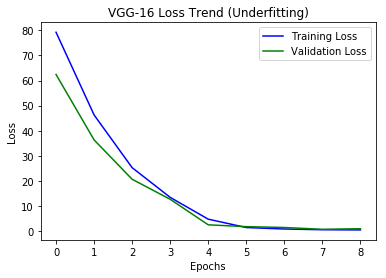

In [35]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend (Underfitting)')
plt.plot(loss[1:], 'blue', label='Training Loss')
plt.plot(val_loss[1:], 'green', label='Validation Loss')
#plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

In [73]:
a=model.predict(resized_images[10])
print a

[[  2.66285151e-01   4.19522196e-01   3.14021021e-01   1.71615247e-04]]


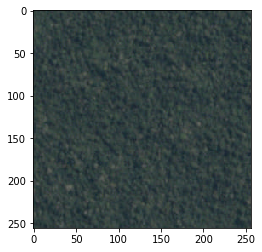

In [76]:
lena = mpimg.imread('/Users/sunchenxi/Desktop/lab/kaggle/amazon/train-jpg/'+fname[2])
plt.imshow(lena) 

### change learning rate

In [34]:
op = RMSprop(lr=1e-4)
ob = 'binary_crossentropy'
def Cnet2():
    
    model = Sequential()

    model.add(Convolution2D(32, 4, 4, border_mode='same', input_shape=(64, 64, 4), activation='relu'))
    model.add(Convolution2D(32, 4, 4, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Convolution2D(64, 4, 4, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    
    model.add(Convolution2D(128, 4, 4, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    

    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.3)))
    
    model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.3)))

    model.add(Dense(4))
   # model.add(Activation('sigmoid'))
    model.add(Activation('softmax')) #Softmax评分
    model.compile(loss=ob, optimizer=op, metrics=['accuracy'])
    return model


model = Cnet2()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (4, 4), padding="same", activation="relu", input_shape=(64, 64, 4...)`
  import sys
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (4, 4), padding="same", activation="relu")`
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), padding="same", activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (4, 4), padding="same", activation="relu")`
  


In [35]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

history = LossHistory()
model.fit(train_x, train_y, batch_size=32, epochs=32,
          validation_split=0.25, verbose=1, shuffle=True, callbacks=[history])

Train on 540 samples, validate on 180 samples
Epoch 1/32
540/540 [==============================] - 19s - loss: 176.4184 - acc: 0.6880 - val_loss: 173.8011 - val_acc: 0.5000
Epoch 2/32
540/540 [==============================] - 17s - loss: 166.5848 - acc: 0.6852 - val_loss: 164.8463 - val_acc: 0.5000
Epoch 3/32
540/540 [==============================] - 19s - loss: 159.3126 - acc: 0.6009 - val_loss: 157.2176 - val_acc: 0.5000
Epoch 4/32
540/540 [==============================] - 18s - loss: 150.7634 - acc: 0.6852 - val_loss: 149.7172 - val_acc: 0.5000
Epoch 5/32
540/540 [==============================] - 17s - loss: 143.1939 - acc: 0.6852 - val_loss: 142.1067 - val_acc: 0.5000
Epoch 6/32
540/540 [==============================] - 19s - loss: 135.6133 - acc: 0.6852 - val_loss: 134.5925 - val_acc: 0.5000
Epoch 7/32
540/540 [==============================] - 17s - loss: 128.1975 - acc: 0.6852 - val_loss: 127.3036 - val_acc: 0.5000
Epoch 8/32
540/540 [==============================] - 17s 

In [45]:
score = model.evaluate(train_x, train_y, verbose=0)  
print('Test score:', score[0])  
print('Test accuracy:', score[1])  

('Test score:', 11.640846702787611)
('Test accuracy:', 0.27777777777777779)


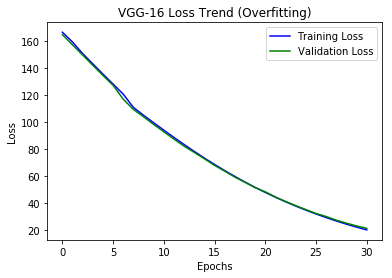

In [36]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend (Overfitting)')
plt.plot(loss[1:], 'blue', label='Training Loss')
plt.plot(val_loss[1:], 'green', label='Validation Loss') 
plt.legend()
plt.show()

In [48]:
model.predict_classes(train_x)

720/720 [==============================] - 8s     


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1,

### 其实并没有过拟合

In [ ]:
def convnet_v3():
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(64, 64, 4), activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(4))
    model.add(Activation('softmax'))
    #model.add(Activation('sigmoid'))

    model.compile(loss=ob, optimizer=op, metrics=['accuracy'])
    return model


model = convnet_v3()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

history = LossHistory()
model.fit(train_x, train_y, batch_size=32, epochs=20,
          validation_split=0.25, verbose=1, shuffle=True, callbacks=[history, early_stopping])

In [ ]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend (Overfitting)')
plt.plot(loss[1:], 'blue', label='Training Loss')
plt.plot(val_loss[1:], 'green', label='Validation Loss')
#plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

### 再次降低学习率
这次是真的overfitting了


In [98]:
op = RMSprop(lr=1e-5)
ob = 'binary_crossentropy'
def Cnet4():
    
    model = Sequential()

    model.add(Convolution2D(32, 4, 4, border_mode='same', input_shape=(64, 64, 4), activation='relu'))
    model.add(Convolution2D(32, 4, 4, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Convolution2D(64, 4, 4, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    
    model.add(Convolution2D(128, 4, 4, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    

    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.3)))
    
    model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.3)))

    model.add(Dense(4))
   # model.add(Activation('sigmoid'))
    model.add(Activation('softmax')) #Softmax评分
    model.compile(loss=ob, optimizer=op, metrics=['accuracy'])
    return model


model = Cnet4()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (4, 4), padding="same", activation="relu", input_shape=(64, 64, 4...)`
  import sys
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (4, 4), padding="same", activation="relu")`
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), padding="same", activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (4, 4), padding="same", activation="relu")`
  


In [101]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

history = LossHistory()
model.fit(train_x, train_y, batch_size=32, epochs=10,
          validation_split=0.25, verbose=1, shuffle=True, callbacks=[history])

Train on 540 samples, validate on 180 samples
Epoch 1/10
540/540 [==============================] - 17s - loss: 176.5038 - acc: 0.6296 - val_loss: 175.4201 - val_acc: 0.6667
Epoch 2/10
540/540 [==============================] - 16s - loss: 175.5853 - acc: 0.6296 - val_loss: 174.5033 - val_acc: 0.6667
Epoch 3/10
540/540 [==============================] - 18s - loss: 174.6701 - acc: 0.6296 - val_loss: 173.5901 - val_acc: 0.6667
Epoch 4/10
540/540 [==============================] - 17s - loss: 173.7583 - acc: 0.6296 - val_loss: 172.6798 - val_acc: 0.6667
Epoch 5/10
540/540 [==============================] - 17s - loss: 172.8497 - acc: 0.6296 - val_loss: 171.7731 - val_acc: 0.6667
Epoch 6/10
540/540 [==============================] - 16s - loss: 171.9445 - acc: 0.6296 - val_loss: 170.8696 - val_acc: 0.6667
Epoch 7/10
540/540 [==============================] - 16s - loss: 171.0426 - acc: 0.6296 - val_loss: 169.9694 - val_acc: 0.6667
Epoch 8/10
540/540 [==============================] - 16s 

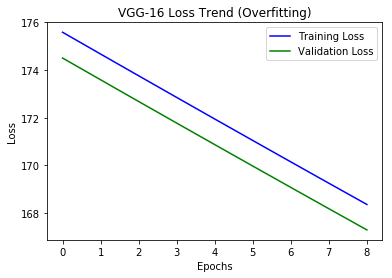

In [102]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend (Overfitting)')
plt.plot(loss[1:], 'blue', label='Training Loss')
plt.plot(val_loss[1:], 'green', label='Validation Loss')
#plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

In [41]:
batch_size=32#每次训练样本个数,太小会训练慢，过拟合，太大会欠拟合
nb_classes=4#一共分成4类
epochs=12#12次迭代
nb_filter=32#卷积核个数
kernel_size=(3,3)#卷积核大小
pool_size=(2,2)#池化大小
model = Sequential()
model.add(Convolution2D(nb_filter, (kernel_size[0], kernel_size[1]),  
                        padding='same',  
                        input_shape= (64, 64, 4)))

model.add(Activation('relu')) 
model.add(Convolution2D(nb_filter, (kernel_size[0], kernel_size[1]))) #卷积层2  
model.add(Activation('relu')) #激活层 
model.add(MaxPooling2D(pool_size=pool_size)) #池化层
model.add(Dropout(0.25)) #神经元随机失活  
model.add(Flatten()) #拉成一维数据  
model.add(Dense(128)) #全连接层1  
model.add(Activation('relu')) #激活层
model.add(Dropout(0.5)) #随机失活 
model.add(Dense(nb_classes)) #全连接层2  
model.add(Activation('softmax')) #Softmax评分
model.compile(loss='categorical_crossentropy',  
              optimizer='adadelta',  
              metrics=['accuracy'])
model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs,  
          verbose=1, validation_split=0.25)

Train on 540 samples, validate on 180 samples
Epoch 1/12
540/540 [==============================] - 28s - loss: 12.0906 - acc: 0.2463 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/12
540/540 [==============================] - 27s - loss: 10.5479 - acc: 0.3426 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 3/12
540/540 [==============================] - 23s - loss: 10.1564 - acc: 0.3685 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 4/12
540/540 [==============================] - 25s - loss: 10.1484 - acc: 0.3704 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 5/12
540/540 [==============================] - 24s - loss: 10.1484 - acc: 0.3704 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 6/12
540/540 [==============================] - 24s - loss: 10.1484 - acc: 0.3704 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 7/12
540/540 [==============================] - 25s - loss: 10.2081 - acc: 0.3667 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 8/12
540/540 [========================